In [1]:
!git clone https://gitlab.com/PKR-808/covid-19-detection-using-bimcv-dataset.git

Cloning into 'covid-19-detection-using-bimcv-dataset'...
remote: Enumerating objects: 3563, done.
remote: Counting objects: 100% (3563/3563), done.
remote: Compressing objects: 100% (3562/3562), done.
remote: Total 3563 (delta 0), reused 3560 (delta 0), pack-reused 0
Receiving objects: 100% (3563/3563), 2.85 GiB | 22.24 MiB/s, done.
Checking out files: 100% (3586/3586), done.


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=36801a6039e1fb042da722f0b7584fb810bba0047386775889114b325b45f673
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 112.9 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [3]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import random
import time

In [4]:
!ls

covid-19-detection-using-bimcv-dataset	sample_data


In [5]:
data_dir = 'covid-19-detection-using-bimcv-dataset'
train_dir = data_dir + '/train'
validation_dir = data_dir + '/validation'
test_dir = data_dir + '/test'

In [6]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(), 
                                          transforms.RandomVerticalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=4, shuffle=True)
len(train_loader)


737

In [7]:
len(test_loader)

100

In [8]:
train_loader

In [9]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

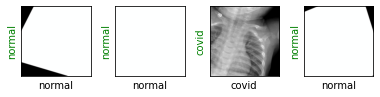

In [10]:
images, labels = next(iter(train_loader))
class_names = ['normal', 'covid']

show_images(images, labels, labels)

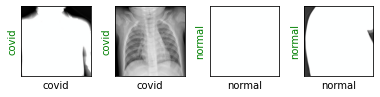

In [11]:
images, labels = next(iter(validation_loader))
show_images(images, labels, labels)

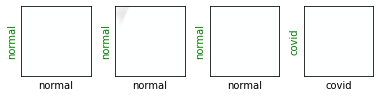

In [12]:
images, labels = next(iter(test_loader))
show_images(images, labels, labels)

In [13]:
# Build and train your network
# Transfer Learning
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 1000)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(1000, 2)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [15]:
# Loss function and gradient descent

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [16]:

# Function for the test pass
def test(model, test_loader, criterion):
    
    test_loss = 0
    accuracy = 0
    
    for images, labels in iter(validation_loader):

        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        probabilities = torch.exp(output)   
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [ ]:
since = 0
for e in range(1,3):
  time_elapsed = 57376
  print('Epoch {} trained in {} hrs {:.0f} mins  and {:.0f} secs'.format(e, time_elapsed//3600, time_elapsed//60%60, time_elapsed%60))

Epoch 1 trained in 15 hrs 56 mins  and 16 secs
Epoch 2 trained in 15 hrs 56 mins  and 16 secs


In [ ]:
# Train the classifier
train_loss, test_loss = [], []
def train_classifier():
        epochs = 2
        steps = 0
        print_every = 40
        start = time.time()

        for e in range(epochs):
            since = time.time()
            model.train()

            running_loss = 0
    
            for images, labels in iter(train_loader):
        
                steps += 1
        
                optimizer.zero_grad()
        
                output = model.forward(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                if steps % print_every == 0:
                
                    model.eval()
                
                    # Turn off gradients for testing, saves memory and computations
                    with torch.no_grad():
                        testing_loss, accuracy = test(model, test_loader, criterion)
                        train_loss.append(running_loss/print_every)
                        test_loss.append(testing_loss/len(test_loader))    
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Testing Loss: {:.3f}.. ".format(testing_loss/len(test_loader)),
                          "Testing Accuracy: {:.3f}".format(accuracy/len(test_loader)))
            
                    running_loss = 0
                    model.train()
            time_elapsed = time.time() - since
            print('Epoch {} trained in {:.0f} hrs {:.0f} mins  and {:.0f} secs'.format(e+1, time_elapsed//3600, time_elapsed//60%60, time_elapsed%60))
        total_time_elapsed = time.time() - start
        print('Training completed in {:.0f} hrs {:.0f} mins {:.0f} secs'.format(total_time_elapsed//3600, total_time_elapsed//60%60, total_time_elapsed%60))                    
train_classifier()

Epoch: 1/2..  Training Loss: 0.699..  Testing Loss: 0.585..  Testing Accuracy: 0.717
Epoch: 1/2..  Training Loss: 0.341..  Testing Loss: 0.555..  Testing Accuracy: 0.723
Epoch: 1/2..  Training Loss: 0.428..  Testing Loss: 0.543..  Testing Accuracy: 0.743
Epoch: 1/2..  Training Loss: 0.529..  Testing Loss: 0.452..  Testing Accuracy: 0.760
Epoch: 1/2..  Training Loss: 0.422..  Testing Loss: 0.464..  Testing Accuracy: 0.770
Epoch: 1/2..  Training Loss: 0.523..  Testing Loss: 0.612..  Testing Accuracy: 0.733
Epoch: 1/2..  Training Loss: 0.449..  Testing Loss: 0.457..  Testing Accuracy: 0.780
Epoch: 1/2..  Training Loss: 0.445..  Testing Loss: 0.525..  Testing Accuracy: 0.740
Epoch: 1/2..  Training Loss: 0.547..  Testing Loss: 0.461..  Testing Accuracy: 0.772
Epoch: 1/2..  Training Loss: 0.476..  Testing Loss: 0.431..  Testing Accuracy: 0.777
Epoch: 1/2..  Training Loss: 0.400..  Testing Loss: 0.421..  Testing Accuracy: 0.775
Epoch: 1/2..  Training Loss: 0.518..  Testing Loss: 0.595..  Test

In [ ]:
def show_preds():
  model.eval()
  images,labels = next(iter(test_loader))
  output = model.forward(images)
  probabilities = torch.exp(output)
  preds = probabilities.max(dim=1)[1]
  show_images(images, labels, preds)


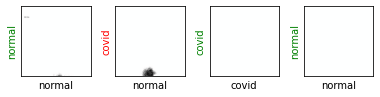

In [ ]:
show_preds()

In [ ]:
pred_list = []
test_list = []

model.eval()
with torch.no_grad():
  for images, labels in iter(test_loader):
    output = model.forward(images)
    probabilities = torch.exp(output)
    preds = probabilities.max(dim=1)[1]
    test_list.append(labels.data.numpy()) 
    pred_list.append(preds.numpy())
  
  pred_list = [a.squeeze().tolist() for a in pred_list]
  test_list = [a.squeeze().tolist() for a in test_list]
  result = sum(pred_list, [])
  result2 = sum(test_list, [])


In [ ]:
confusion_matrix(result2, result)

array([[104,  96],
       [ 44, 156]])

In [ ]:
print(classification_report(result, result2))

              precision    recall  f1-score   support

           0       0.52      0.70      0.60       148
           1       0.78      0.62      0.69       252

    accuracy                           0.65       400
   macro avg       0.65      0.66      0.64       400
weighted avg       0.68      0.65      0.66       400



In [ ]:
def validation_accuracy(model, validation_loader):

    # Doing validation on the validation set
    model.eval()

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(validation_loader):
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(validation_loader)))    
        
        
validation_accuracy(model, validation_loader)

Test Accuracy: 0.6499999761581421


In [ ]:
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Test loss')
plt.legend(frameon=False)
plt.show()

NameError: ignored

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls content/gdrive/My Drive

ls: cannot access 'content/gdrive/My': No such file or directory
ls: cannot access 'Drive': No such file or directory


In [ ]:
'''model_save_name = 'vgg16classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
'''model_save_name = 'vgg16classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# Save the checkpoint

def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }
    vggmodel_save_name = 'vgg16classifier.pt'
    vgg_path = F"/content/gdrive/My Drive/{vggmodel_save_name}"
    torch.save(checkpoint, vgg_path)
    
save_checkpoint(model)

In [18]:
from collections import OrderedDict

# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 1000)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(1000, 2)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [19]:
vggmodel_save_name = 'vgg16classifier.pt'
vgg_path = F"/content/gdrive/My Drive/{vggmodel_save_name}"
model = load_checkpoint(vgg_path)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
#Image pre-processing before making prediction using the model
from PIL import Image  

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [21]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('covid-19-detection-using-bimcv-dataset/validation/Covid-19/COVID-19 (147).png')
imshow(image)

ValueError: ignored

In [ ]:
# Implement the code to predict the class from an image file

def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    print(model.class_to_idx.items())
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes
    
probs, classes = predict('covid-19-detection-using-bimcv-dataset/validation/Covid-19/COVID-19 (202).png', model)   
print(probs)
print(classes)

dict_items([('Covid-19', 0), ('Normal', 1)])
[0.6010609269142151, 0.3989390432834625]
['Normal', 'Covid-19']
